In [1]:
import torch 
import torch.nn as nn

/home/st123439/work/cuda116/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# YOLO ARCHITECTURE

<img src="./assets/YOLO_Architecture_from_the_original_paper_.png">

Image Reference: https://www.datacamp.com/blog/yolo-object-detection-explained

The following code is inspired and taken from this repo : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO/

## Lets build our model

In [2]:
""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4], # list architecture
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)            # Not used in original implementation!
        self.leakyrelu = nn.LeakyReLU(0.1) 
        
    def forward(self,x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))        

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fc(**kwargs)
    
    def forward(self,x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, out_channels = x[1], kernel_size=x[0], stride=x[2], padding=x[3],)]
                in_channels = x[1]

            if type(x) == str:
                layers += [
                    nn.MaxPool2d(kernel_size=2, stride=2)]

            if type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, out_channels = conv1[1], kernel_size= conv1[0], stride=conv1[2], padding=conv1[3],)]
                    layers += [
                        CNNBlock(conv1[1], out_channels = conv2[1], kernel_size= conv2[0], stride=conv2[2], padding=conv2[3],)]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)
    
    def _create_fc(self, split_size, num_boxes, num_classes):
        S,B,C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S , 4096),
            nn.Dropout(0.5),                         # not implemented in paper
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S*S*(C + B*5)),           # C+5*B = 30
        )

In [5]:
# Test our model

model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
print(model)

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [6]:
x = torch.randn(2, 3, 448, 448)
print(model(x).shape)                      # 7*7*30 = 1470

torch.Size([2, 1470])


## Lets build our Loss Function

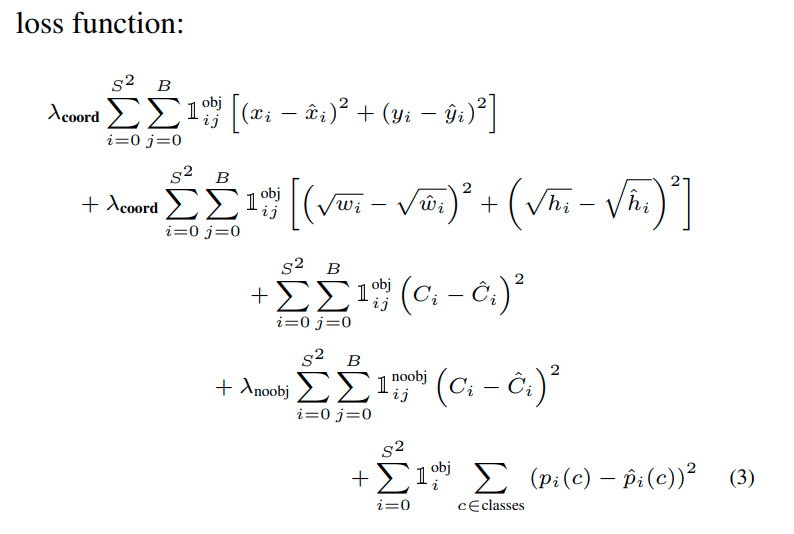

In [7]:
from dataset import VOCDataset
from utils import intersection_over_union

In [8]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [9]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)

In [10]:
seed = 123
torch.manual_seed(seed)

In [11]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

In [12]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [13]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [14]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "data/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)

In [ ]:
main()

Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.87it/s, loss=722]    

Mean loss was 890.2070566813151


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.61it/s, loss=401]

Mean loss was 542.6352996826172


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.81it/s, loss=501]

Mean loss was 485.54258219401044


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.67it/s, loss=537]

Mean loss was 439.6402537027995


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.81it/s, loss=305]

Mean loss was 364.97760009765625


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.79it/s, loss=306]

Mean loss was 325.881591796875


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.57it/s, loss=198]

Mean loss was 275.13560994466144


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.87it/s, loss=225]